### Idea

Create a Markov Chain to analyze how different types of students are led to the different paths. The feature space will be a reduced space clustered with spectral clustering

#### Import libraries

In [1]:
# Input
# from db import PythonProblems
import io

#DB
from questions.models import Solution, Cluster

# Helpers
import numpy as np
import pickle

# Preprocessing
import tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD, NMF

# Distance
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, pairwise_kernels

# Learning
from clustering import Clustering
from questions.sampling import get_next_sample
from analyzer import python_analyzer

# Visualization
from plot2d import Plot2D
import matplotlib.pyplot as plt
import seaborn as sns
from generate_pdf import PDFReport


%matplotlib inline

In [2]:
## Cleaning database
last_id = 132
problems = Problem.objects.filter(id__gt=last_id)
solutions_obj = Solution.objects.filter(problem__in=problems).update(ignore=True)
print("Problems to be ignored: %d" % problems.count())

problems = Problem.objects.filter(id__lte=last_id)
# problems = Problem.objects.all()
print("Problems to be used: %d" % problems.count())

solutions_obj = Solution.objects.filter(problem__in=problems, ignore=False).order_by('id')
# solutions_obj = Solution.objects.all().order_by('id')
print("Solutions to be used: %d" % solutions_obj.count())

docs_id = []
questions = []
solutions = []

# Fill separated structures
for sol in solutions_obj:
    docs_id.append(sol.id)
    questions.append(sol.problem.content)
    solutions.append(sol.content)

print("Got %d documents" %(solutions_obj.count()))

Problems to be ignored: 591
Problems to be used: 132
Solutions to be used: 54
Got 54 documents


***Limitações do parser:***

***1. Variável e nome reservado são do mesmo tipo. Não consigo separar sem fazer uma pré-lista. Mas pode ser o critério para ajustar o CountVectorizer***

***2. Não é possível processar solução sintaticamente errada. Talvez uma tokenização básica possa ajudar quando esse for o caso e já é uma indicação de que está errado.***

### Preprocessing solutions into bag of words ###

In [3]:
def create_bag_of_words(docs, vectorizer_method, binary=False, min_df=0.2):
    vectorizer = vectorizer_method(analyzer = python_analyzer,
                                   binary=binary,
                                   min_df=min_df) 
    train_data_features = vectorizer.fit_transform(docs)
    try:
        train_data_features = train_data_features.toarray()
    # It's already an array
    except AttributeError:
        pass
    return train_data_features, vectorizer, vectorizer.get_feature_names()

In [4]:
# %load vectorizer.py
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from analyzer import python_analyzer
import numpy as np


class NCutVectorizer(object):
    def __init__(self, analyzer, binary, min_df):
        self.vectorizer = CountVectorizer(analyzer = python_analyzer,
                                          binary=binary,
                                          min_df=min_df)

    def fit_transform(self, docs):
        train_data_features = self.vectorizer.fit_transform(docs)
        train_data_features = train_data_features.toarray()

        # Calculate NCut-weight
        doc_mat_norm = normalize(train_data_features)
        S = np.dot(doc_mat_norm.T, doc_mat_norm) + 0.001
        D = np.power(np.sum(S, axis=1), -0.5) * np.eye(S.shape[0])
        Y = np.dot(D, train_data_features.T)
        return Y.T
    
    def get_feature_names(self):
        return self.vectorizer.get_feature_names()


In [19]:
train_data_features, vectorizer, feature_names = create_bag_of_words(solutions, NCutVectorizer, 
                                                                     binary=True, min_df=0.35)
# Remove rows containing only zeros (weird exercises)
solution_sample = train_data_features[~(train_data_features==0).all(1)]

### Reducing dimensionality

In [6]:
def get_curve_knee(x, y):
    """ Source: inding a “Kneedle” in a Haystack: Detecting Knee Points in System Behavior 
    https://raghavan.usc.edu//papers/kneedle-simplex11.pdf"""
    
    # Set baseline curve
    x_init, y_init = x[0], y[0]
    x_final, y_final = x[-1], y[-1]
    # Plot it
    plt.plot([x_init, x_final], [y_init, y_final])
    
    # Calculate line coefficients
    a = (y_final - y_init)/(x_final - x_init)
    b = y_init - a*x_init
    y_baseline_list = []
    diff = []
    for idx in range(len(x)):
        x_baseline = x[idx]
        y_baseline = a*x_baseline + b
        y_baseline_list.append(y_baseline)
        diff.append(abs(y[idx] - y_baseline))
        plt.plot([x[idx], x_baseline], [y[idx], y_baseline], c='gray')
        
    # Get optimal value
    max_diff = max(diff)
    max_diff_idx = diff.index(max_diff)
    plt.plot([x[max_diff_idx], x[max_diff_idx]], [y[max_diff_idx], y_baseline_list[max_diff_idx]], c='red')
    
    # Return optimal number of components
    return max_diff_idx+1  

Optimal number of components: 12
Explained variance: 0.91


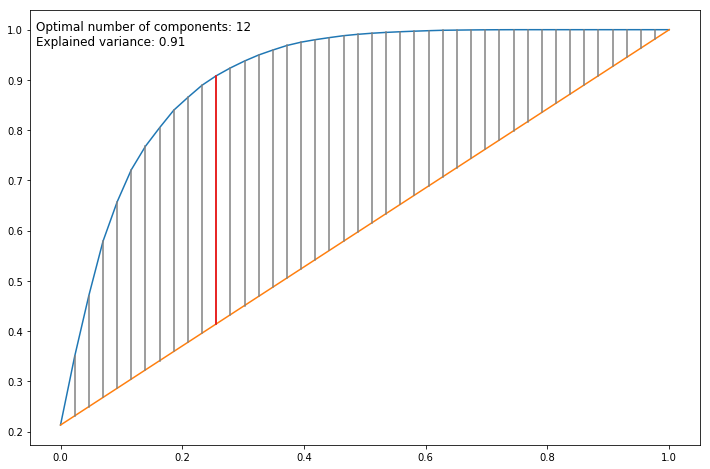

In [21]:
cum_variance = []
# for i in range(1,min(solution_sample.shape)+1):
#     solution_reduced = NMF(n_components=i)
#     solution_reduced.fit(solution_sample)
#     cum_variance.append(solution_reduced.reconstruction_err_)
    
solution_reduced = PCA(n_components=min(solution_sample.shape))
solution_reduced.fit(solution_sample)
    
# # Calculate cumulative sum of explained variance percentage
# # Normalize axis between 0 and 1 to calculate best cutoff point (curve knee)
dimensions = np.linspace(0,1,min(solution_sample.shape))
cum_variance = np.cumsum(solution_reduced.explained_variance_ratio_)
plt.figure(figsize=(12,8))
plt.plot(dimensions, cum_variance)
n_components = get_curve_knee(dimensions, cum_variance)
text = "Optimal number of components: %d\n" % n_components
text += "Explained variance: %.2f" % cum_variance[n_components-1]
# text += "Reconstruction error: %.2f" % cum_variance[n_components-1]
plt.text(-0.04, 0.97, text, fontsize=12)
print(text)
plt.show()

### Cluster solutions

In [22]:
def _generate_random_state():
    seed = np.random.randint(2**32 - 1)
    return seed
seed = _generate_random_state()
solution_reduced = PCA(n_components=n_components, random_state=seed).fit(solution_sample)
# solution_reduced = PCA(n_components=3, random_state=seed).fit(solution_sample)
solution_sample_reduced = solution_reduced.transform(solution_sample)
seed = _generate_random_state()
# document_topic = cluster.SpectralClustering(n_clusters=3, 
#                                         assign_labels="discretize").fit_predict(X)

In [64]:
solution_sample_reduced.shape

(54, 12)

4049318698


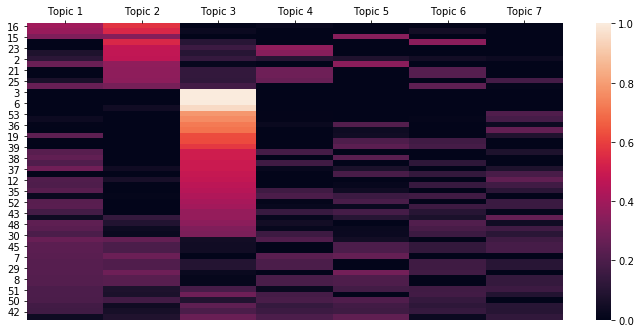

Count per class:
Topic 1: 6
Topic 2: 14
Topic 3: 31
Topic 4: 3


IndexError: index 4 is out of bounds for axis 0 with size 4

In [16]:
# clustering = Clustering(handler.X, )
# clustering = Clustering(solution_sample_reduced, 13)
clustering = Clustering(solution_sample, 7)
clustering.seed = 4049318698
# clustering.seed = 803418030
# clustering.seed = 1707571604
# clustering.seed = 1962052166
# clustering.seed = 1172829407
# clustering.seed = 0
# clustering._generate_random_state()
model, document_topic, word_topic = clustering.nmf()
# model, document_topic, word_topic = clustering.spectral_clustering()
# model, document_topic, word_topic = clustering.gaussian_mixture()
# model, document_topic, word_topic = clustering.lda()
# model, document_topic, word_topic = clustering.hierarchical()
print(clustering.seed)
clustering.plot_topic_distribution()

print("Count per class:")
clusters = clustering.document_topic.argmax(axis=1)
counts = np.unique(clusters, return_counts=True)
for i in range(clustering.k):
    print("Topic %d: %d" % ((i+1), counts[1][i]))

In [ ]:
plt.scatter(solution_sample_reduced[:,0], solution_sample_reduced[:,1], c=clusters)

In [10]:
def print_top_words(model, feature_names, n_top_words):
    top_words = []
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        names = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words.append(names)
        message += ", ".join(names)
        print(message)
    print()
    return top_words

In [11]:
print("\nWords per topic:")
top_words = print_top_words(model, feature_names, 5)


Words per topic:
Topic #0: return, is_indent, is_dedent, def, is_block is_indent
Topic #1: False, True, True is_dedent, False is_dedent, is_dedent is_dedent
Topic #2: sentence is_block is_indent, sentence is_block, in sentence, is_dict, is_attribution is_dict
Topic #3: is_class split, split, is_class join, is_string is_class join, join
Topic #4: is_list for, is_attribution is_list for, is_attribution is_list, is_class append, append
Topic #5: is_string is_dedent, else, is_dedent else is_block, else is_block is_indent, else is_block
Topic #6: is_op_logic is_number is_block, is_number is_block is_indent, is_number is_block, is_op_logic is_number, is_block is_indent return
Topic #7: total, return total, return total is_dedent, total is_dedent, total is_attribution
Topic #8: is_dedent is_dedent return, item in, item, for item, for item in
Topic #9: i in range, i is_dedent, for i in, i in, for i
Topic #10: range is_number is_number, is_number is_number is_block, range is_number, is_number 

### Get next sample

Set initial matrices

In [17]:
# Create X as an empty belief state (X is the machine's model of the student's distribution)
X = np.zeros(clustering.document_topic.shape) # nS x nC
print(X.shape)

# Create Y as a document_topic matrix. For the first version, each document belongs to one topic
Y_col = clustering.document_topic.argmax(axis=1) # nS x nC
Y = np.zeros(clustering.document_topic.shape)
for idx in range(Y.shape[0]):
    Y[idx, Y_col[idx]] = 1

# Create W as a similarity matrix
W = cosine_similarity(clustering.X) # nS x nS
print(W.shape)

with open('similarity.pkl', 'wb') as picklefile:
    pickle.dump(W, picklefile)

# Set L as an unlabelled set
L = []

(54, 7)
(54, 54)


#### Visualization
Reduce to 2 dimensions using TSNE

3338819871


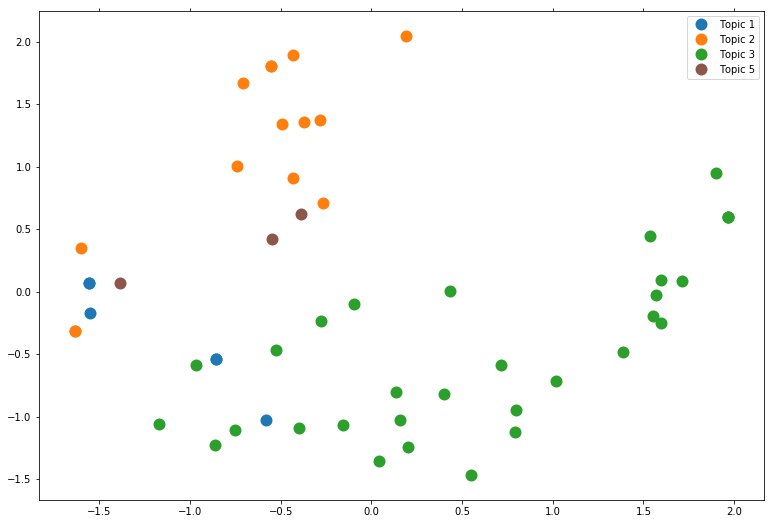

3338819871


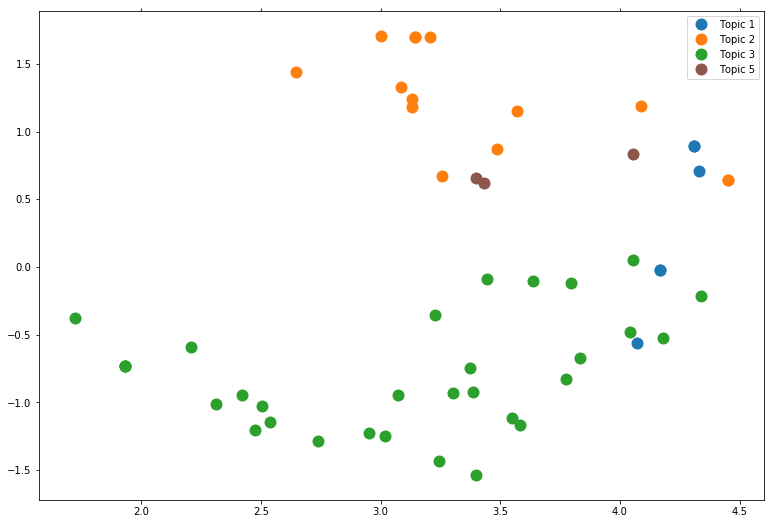

3338819871


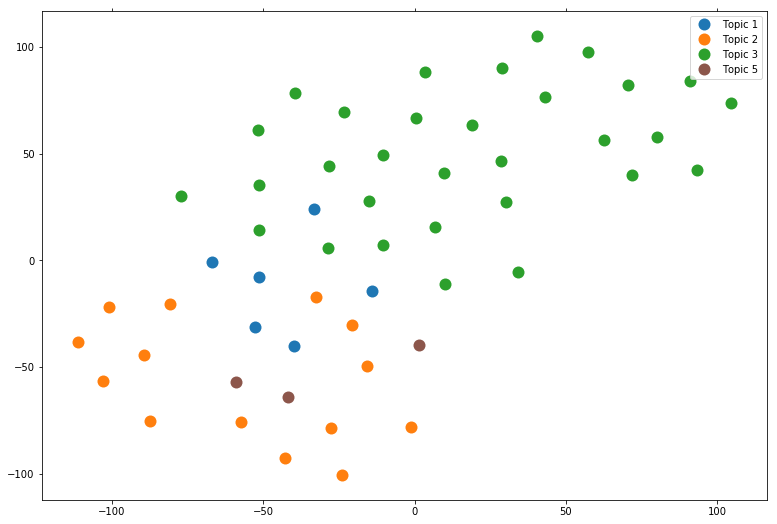

3338819871


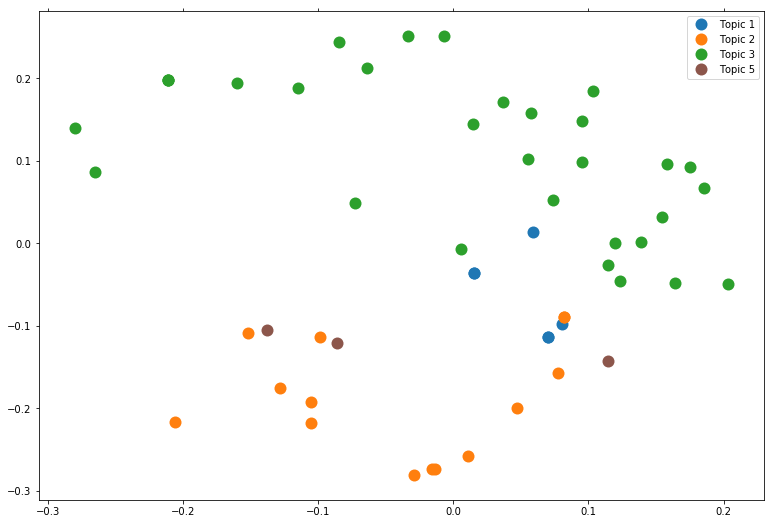

In [18]:
# %%time
# cluster_names = ['', 'conditional', 'dict', 'file', 'function', 'list', 'loop'] #'math', 'string']
cluster_names = ["Topic %d" % (i+1) for i in range(clustering.k)]
doc_category = ["Topic %d" % (i+1) for i in clustering.document_topic.argmax(axis=1)]
doc_category = ["Topic %d" % (i+1) for i in clustering.document_topic.argmax(axis=1)]
handler = Plot2D(clusters=cluster_names, doc_category=doc_category, doc_id=docs_id)
handler._generate_random_state()
# handler.seed = 14875623

# Reduce using PCA
handler.reduce_pca(solution_sample)
print(handler.seed)
handler.plot(show_clusters=True, savefig='problems_20190101_nmf_4049318698_exp_1463_pca.png')

# Reduce using SVD
handler.reduce_svd(solution_sample)
print(handler.seed)
handler.plot(show_clusters=True, savefig='problems_20190101_nmf_4049318698_exp_1463_svd.png')

# Reduce using TSNE
handler.reduce_tsne(solution_sample)
print(handler.seed)
handler.plot(show_clusters=True, savefig='problems_20190101_nmf_4049318698_exp_1463_tsne.png')

# Reduce using MDS
handler.reduce_mds(solution_sample)
print(handler.seed)
handler.plot(show_clusters=True, savefig='problems_20190101_nmf_4049318698_exp_1463_mds.png')

sample = handler.X
y = clustering.document_topic.argmax(axis=1)
# fig = plt.figure(figsize=(10,5))
# plt.scatter(x=sample[:,0], y=sample[:,1], c=y, s=100)

/home/lmoraes/miniconda/envs/machine_teaching/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013/Debian)
 restricted \write18 enabled.
entering extended mode
(./problems_20190101.tex
LaTeX2e <2011/06/27>
Babel <3.9h> and hyphenation patterns for 3 languages loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/base/fontenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.def))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/utf8.def
(/usr/share/texlive/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/share/texlive/texmf-dist/tex/latex/base/omsenc.dfu)))
(/usr/share/texmf/tex/latex/lm/lmodern.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/ts1enc.def
(/usr/share/texli

CalledProcessError: Command '['pdflatex', '--interaction=nonstopmode', 'problems_20190101.tex']' returned non-zero exit status 1.

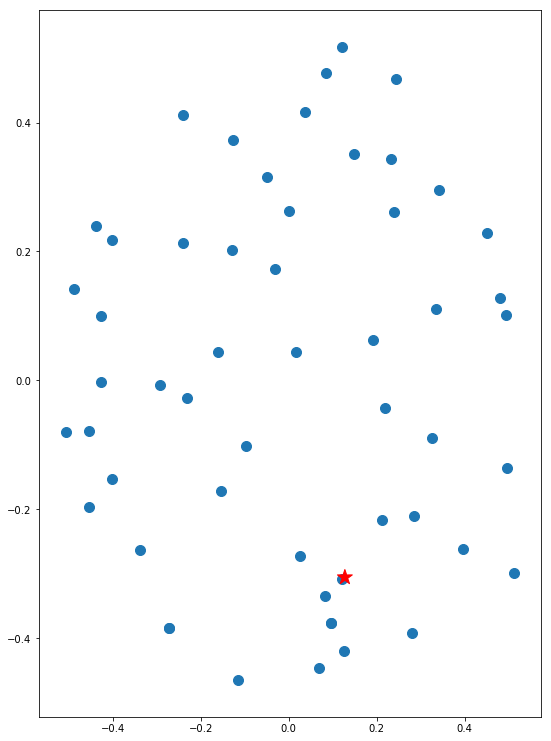

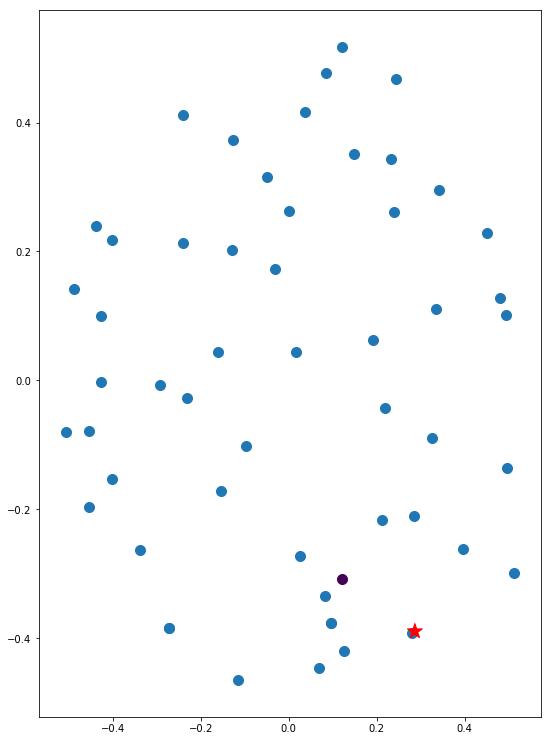

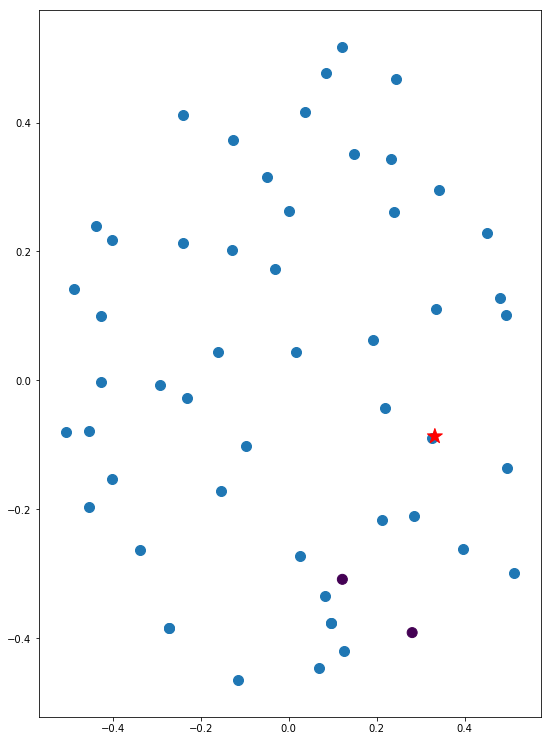

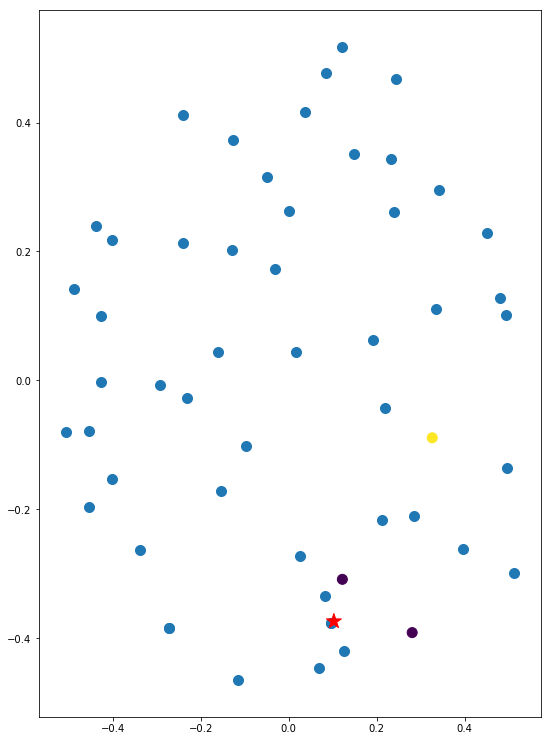

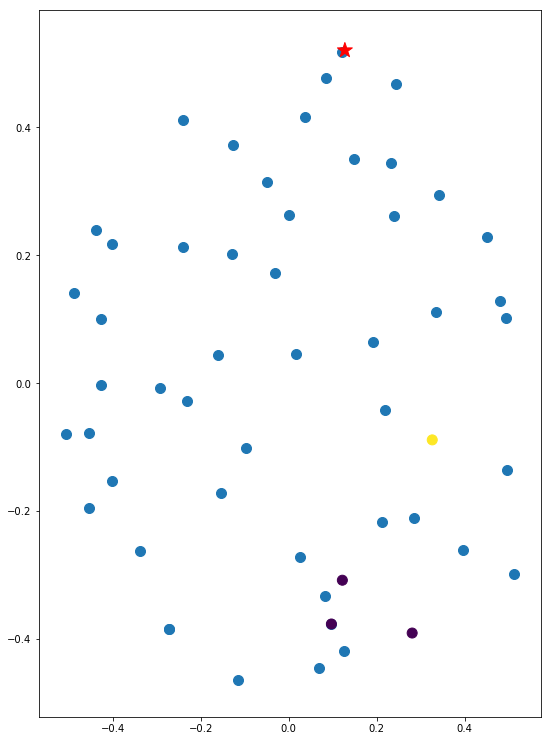

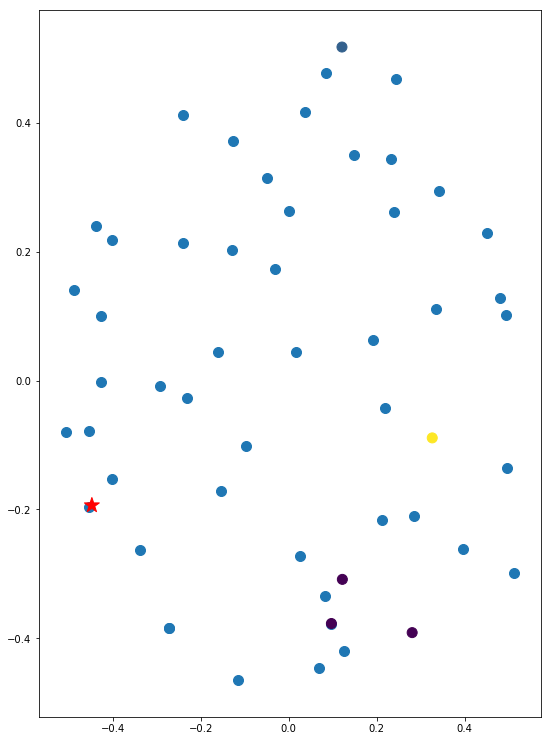

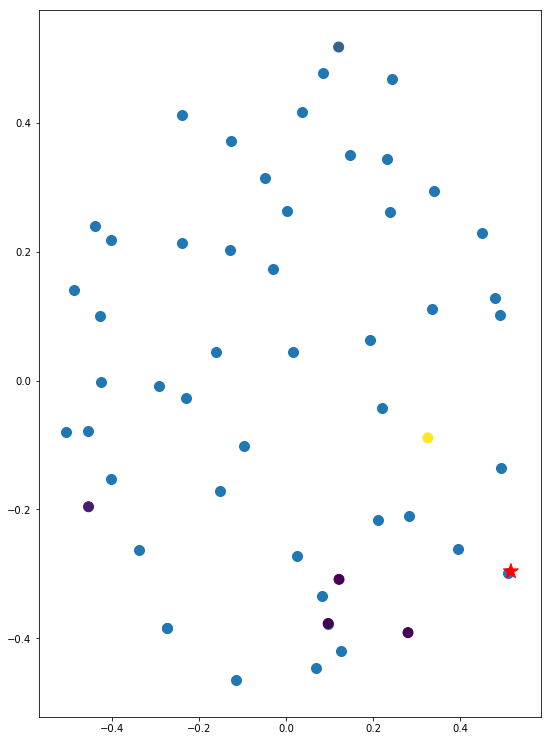

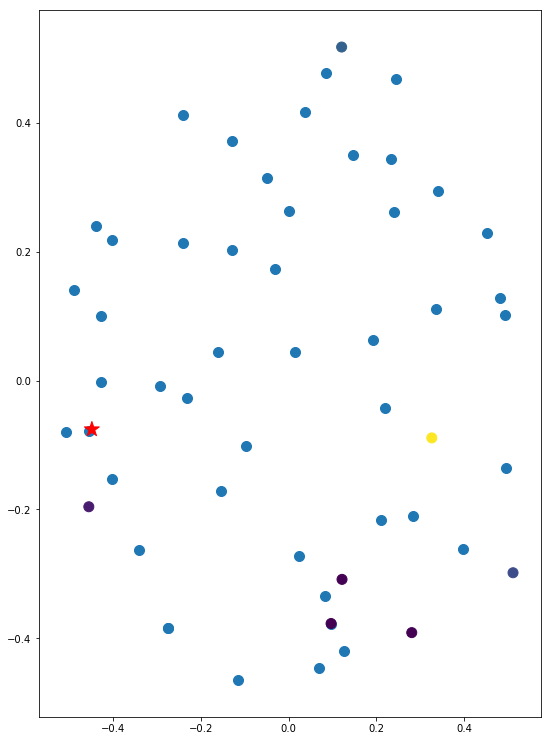

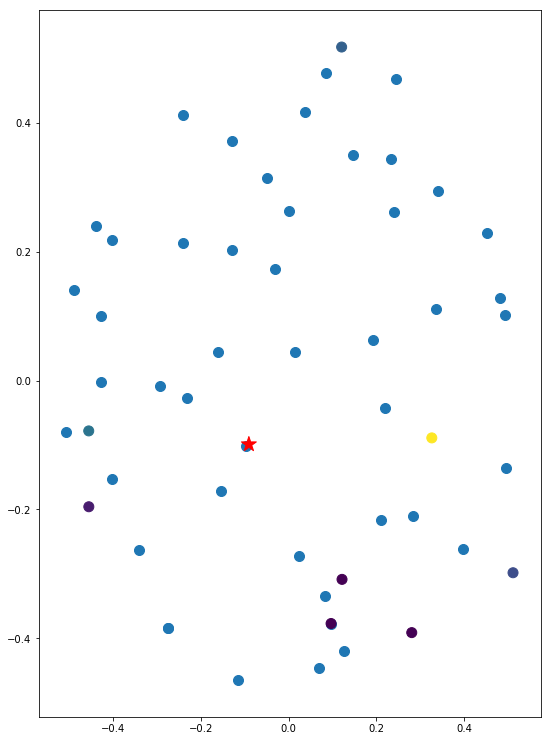

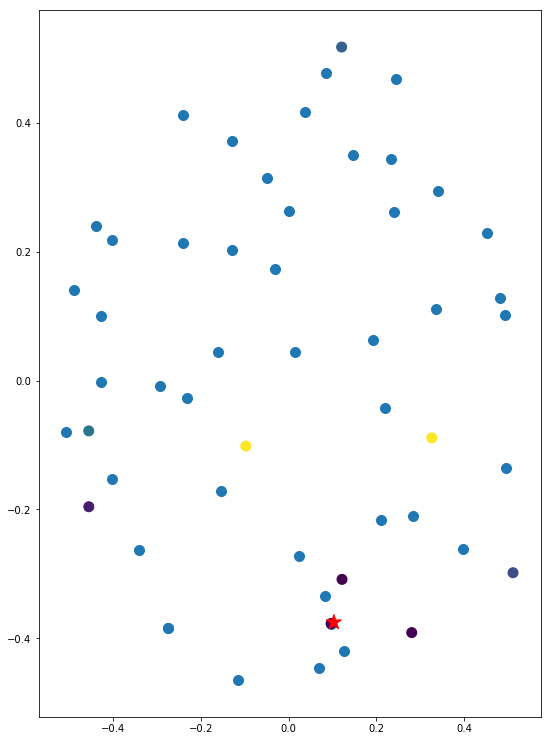

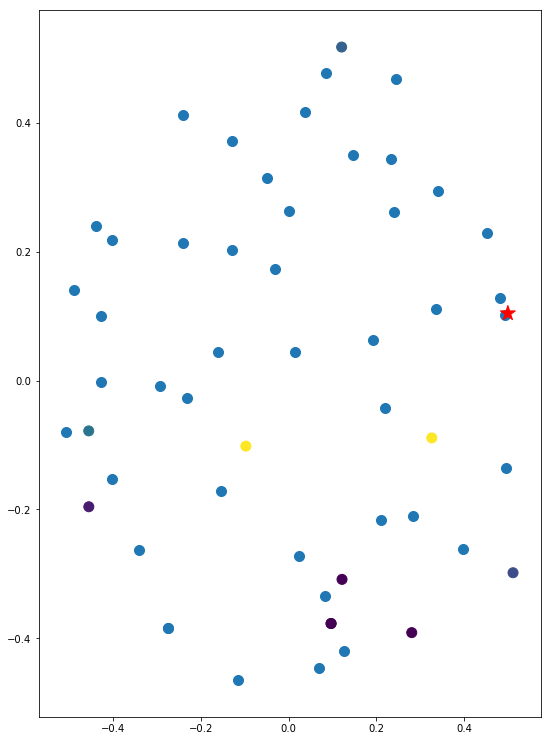

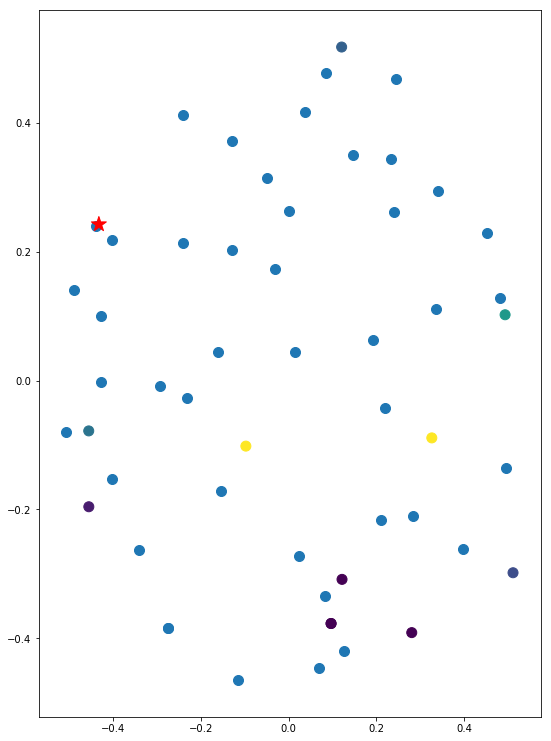

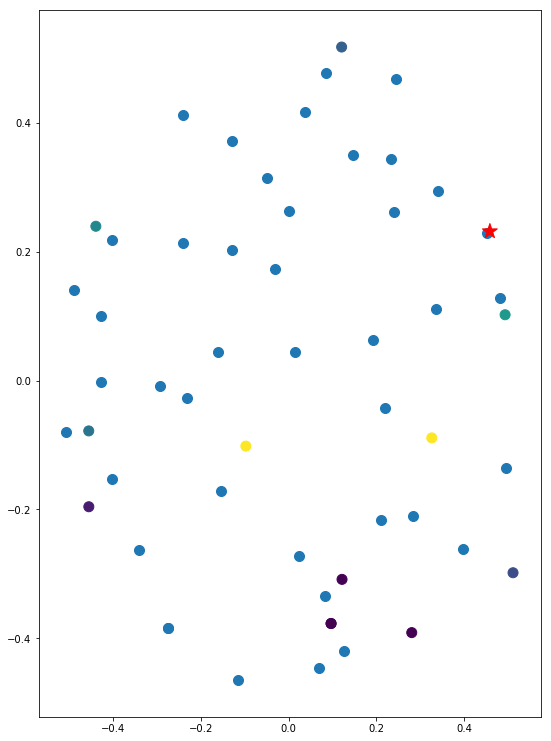

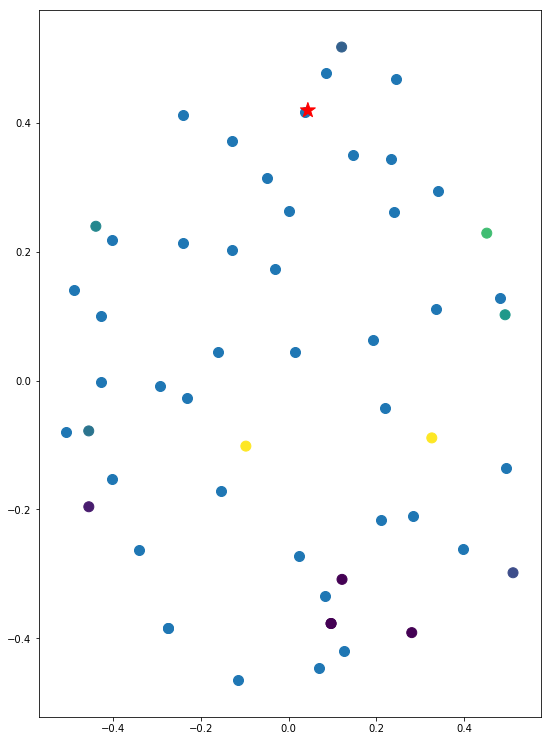

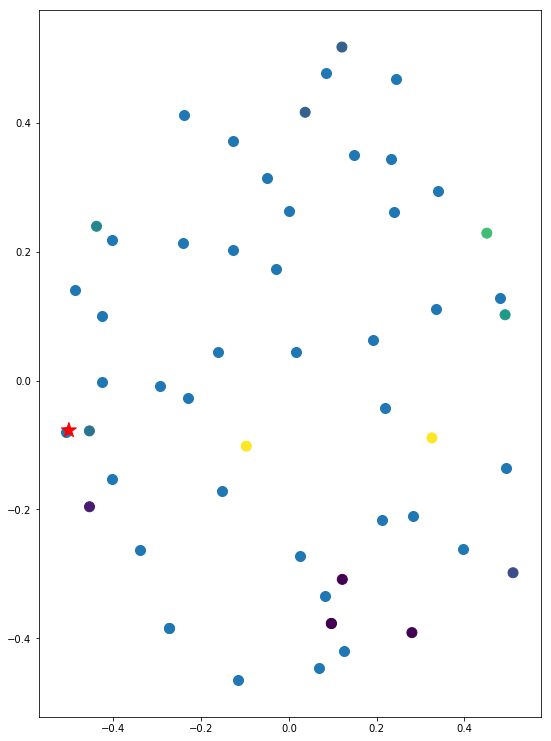

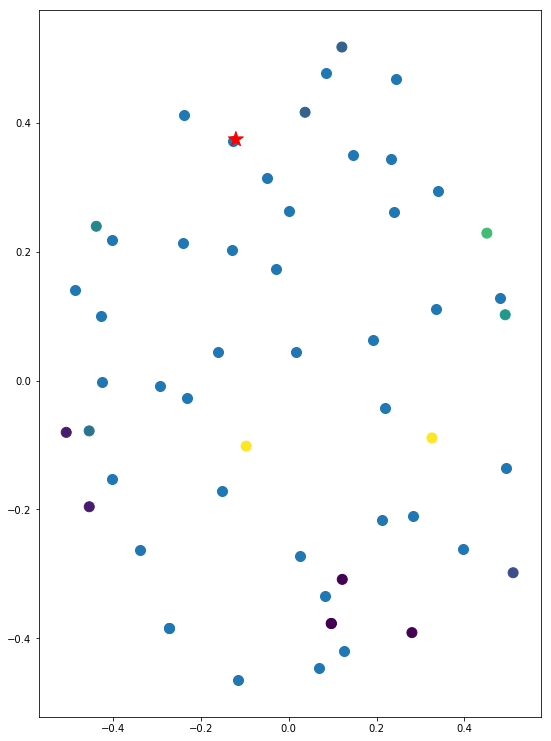

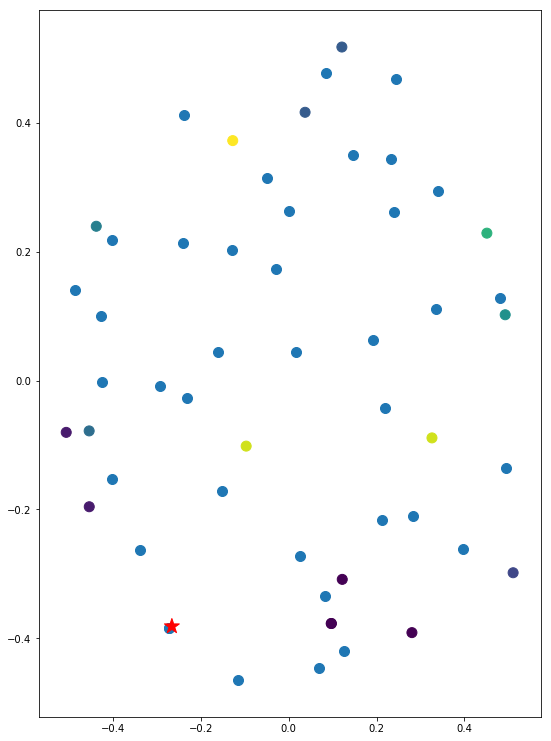

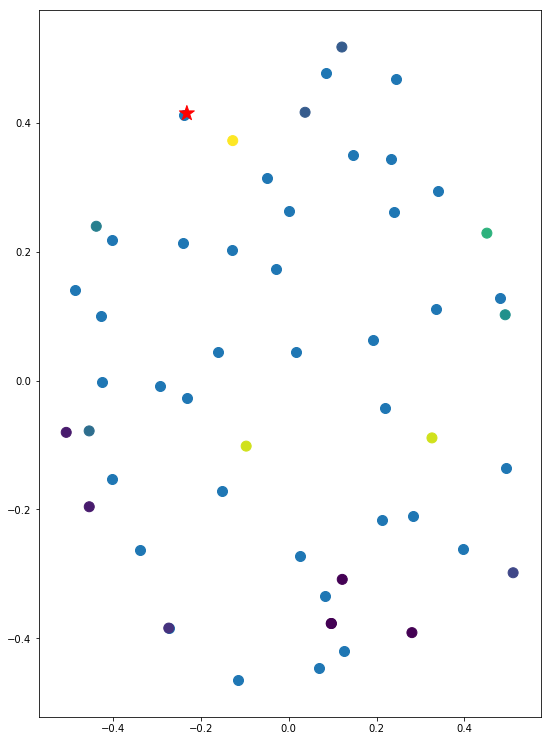

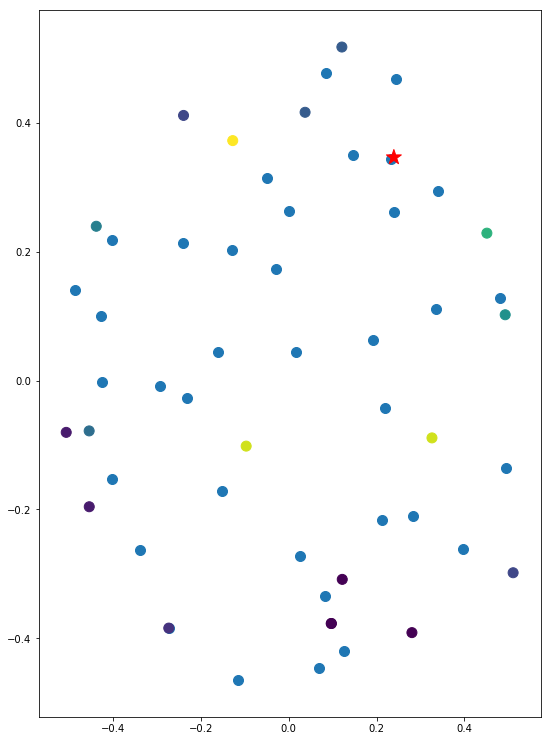

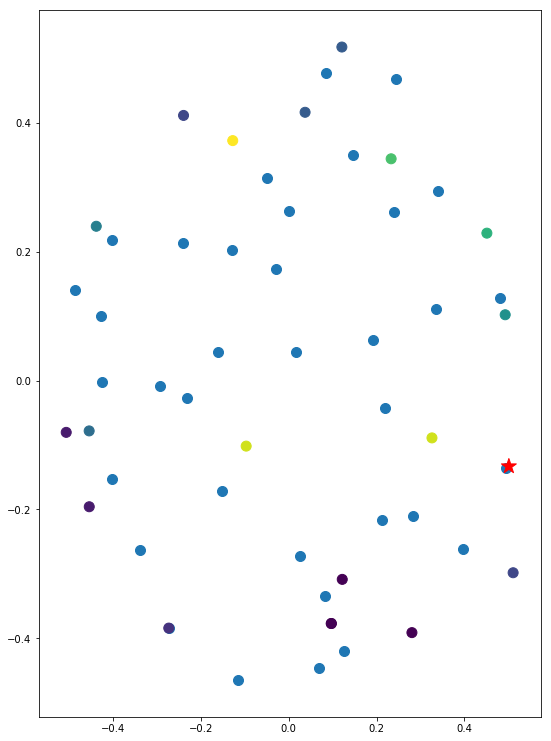

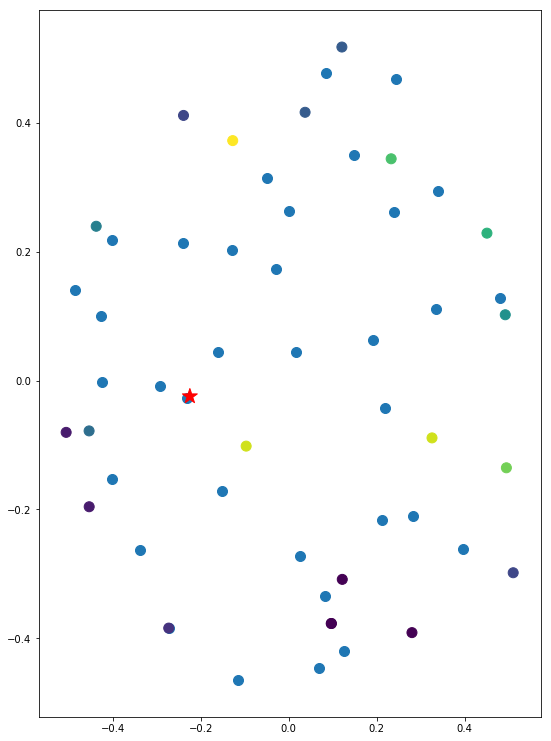

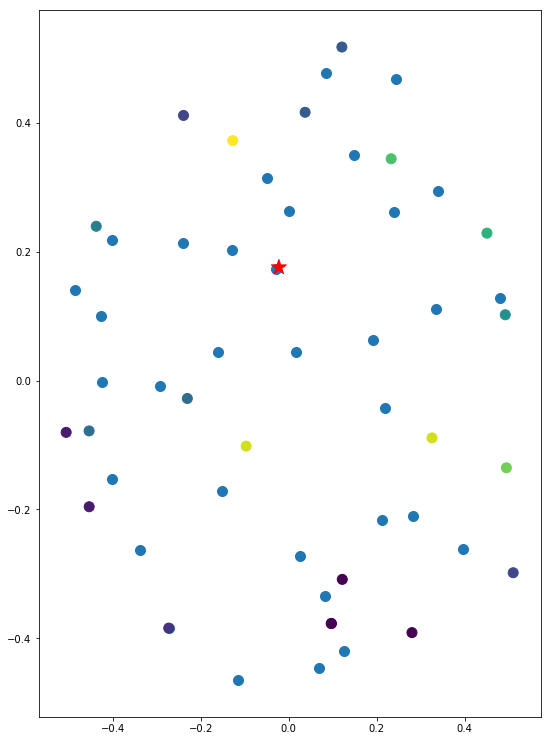

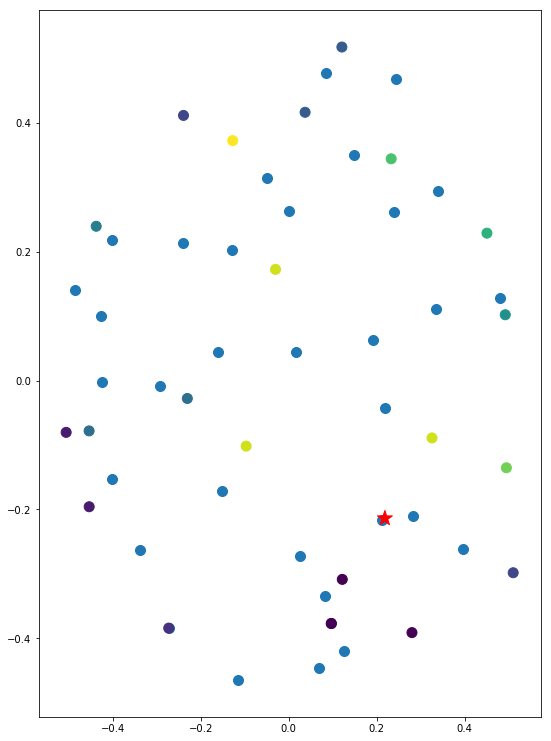

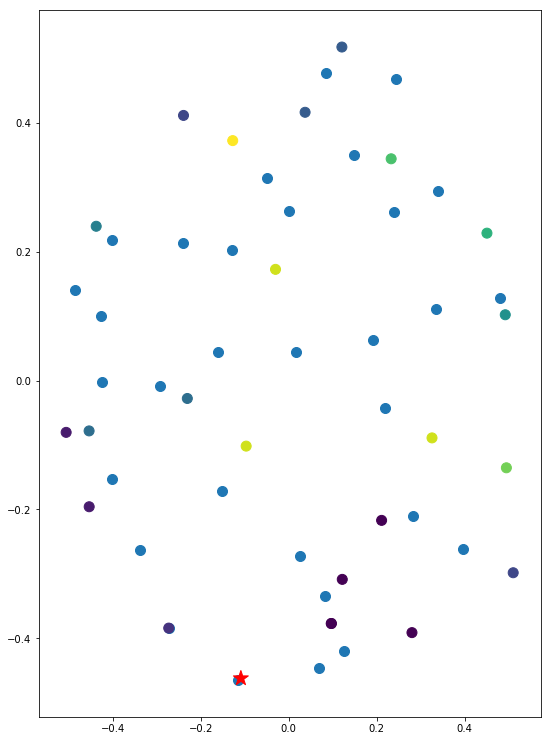

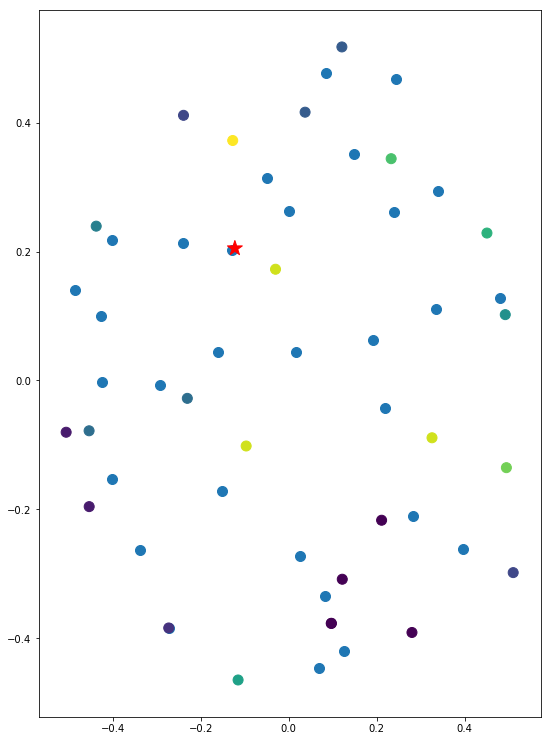

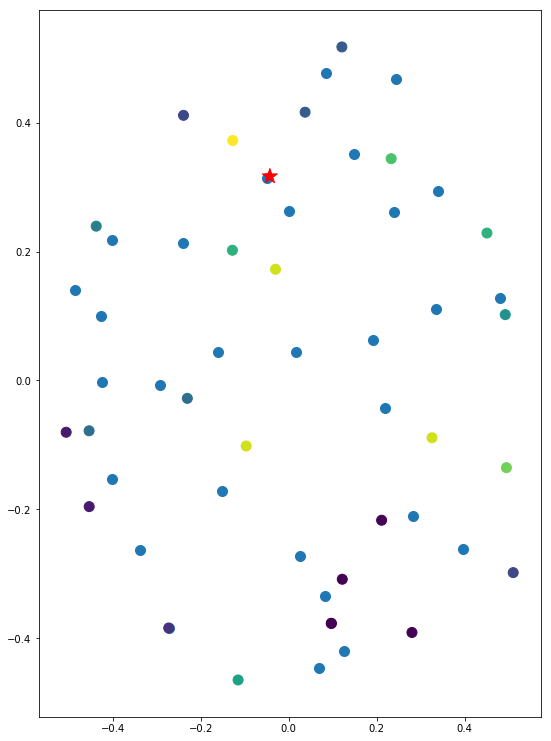

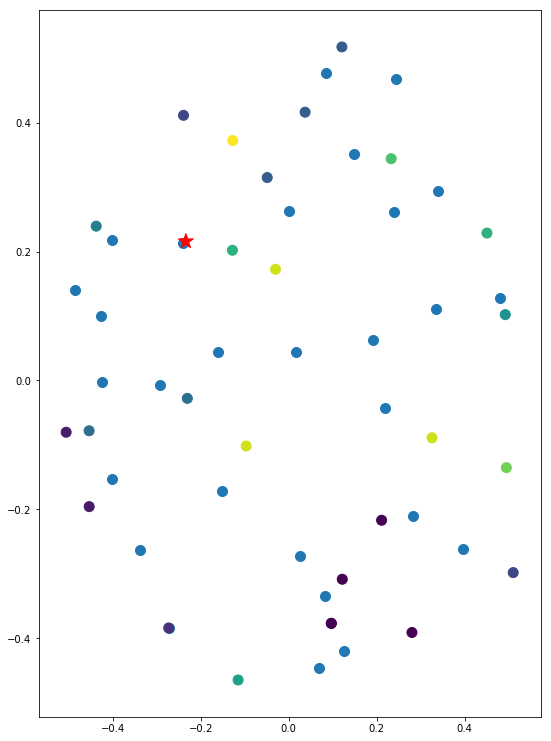

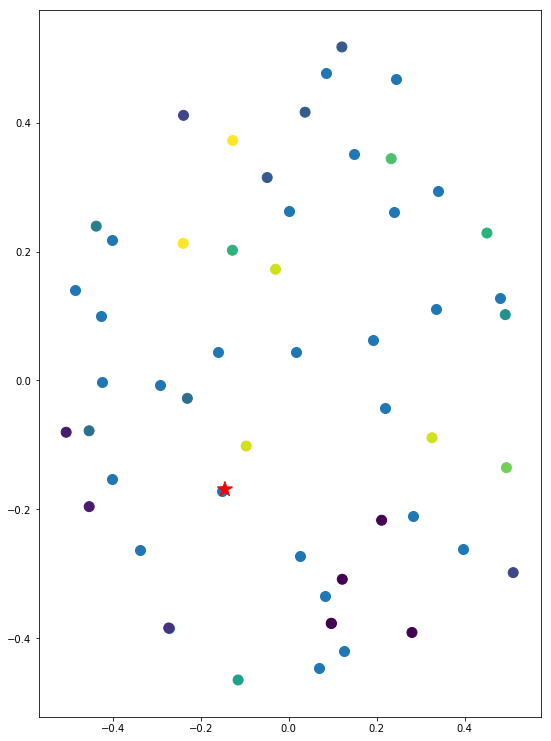

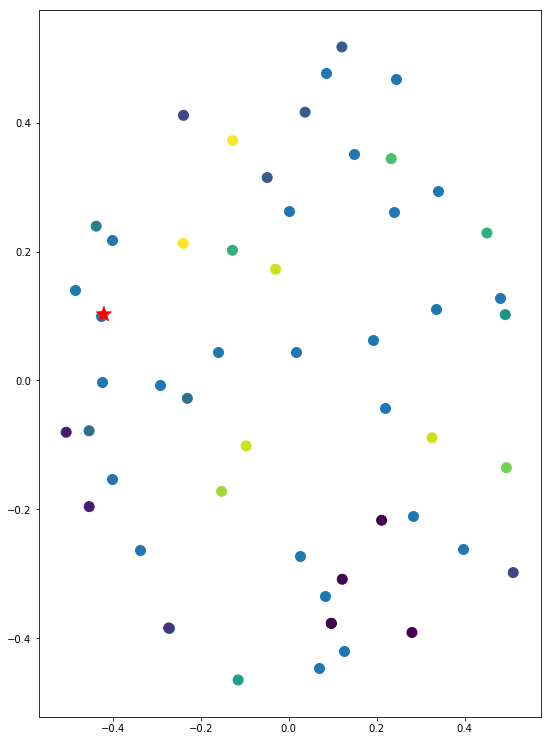

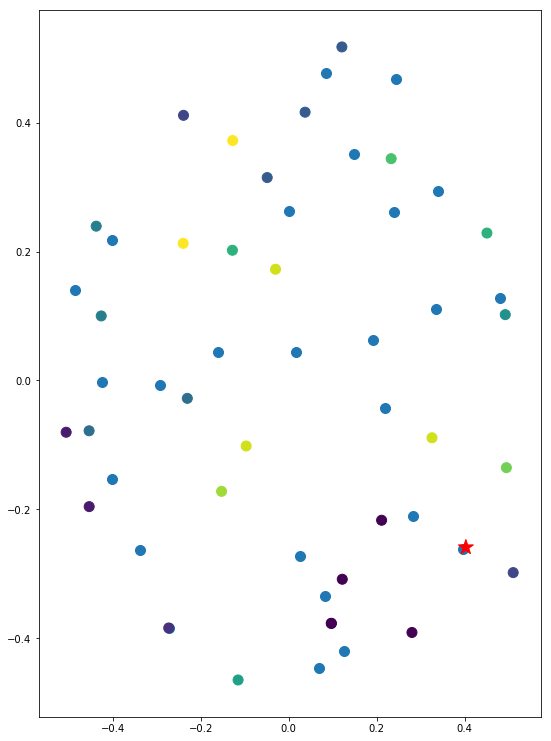

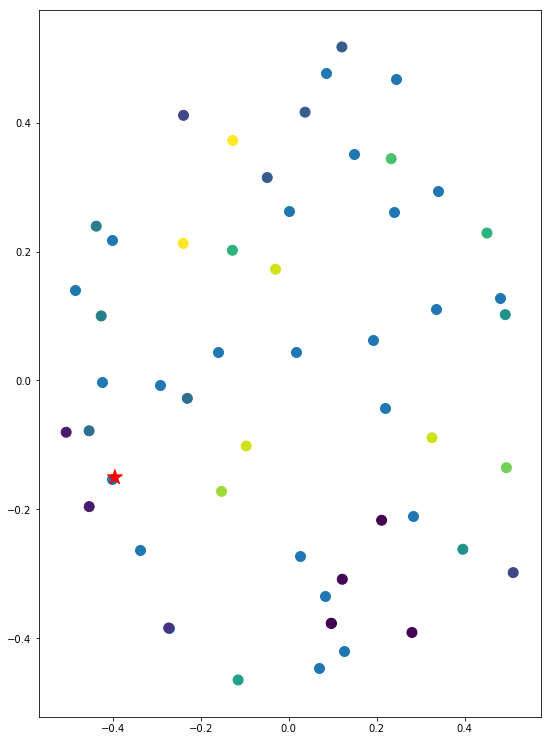

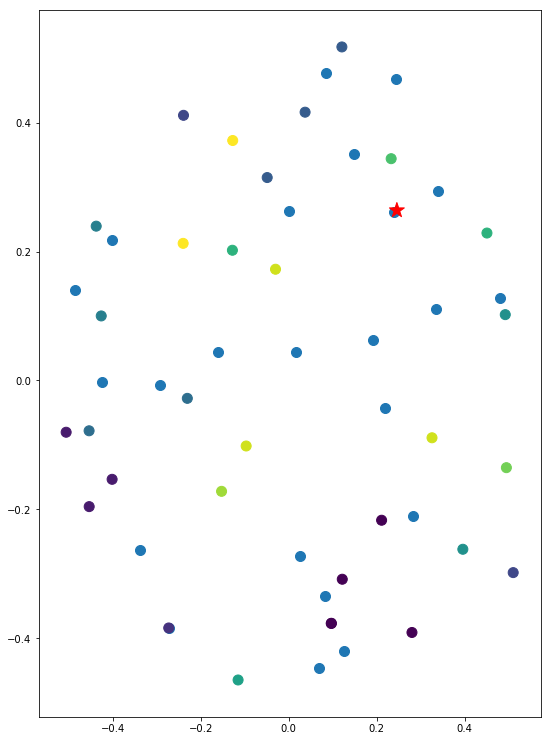

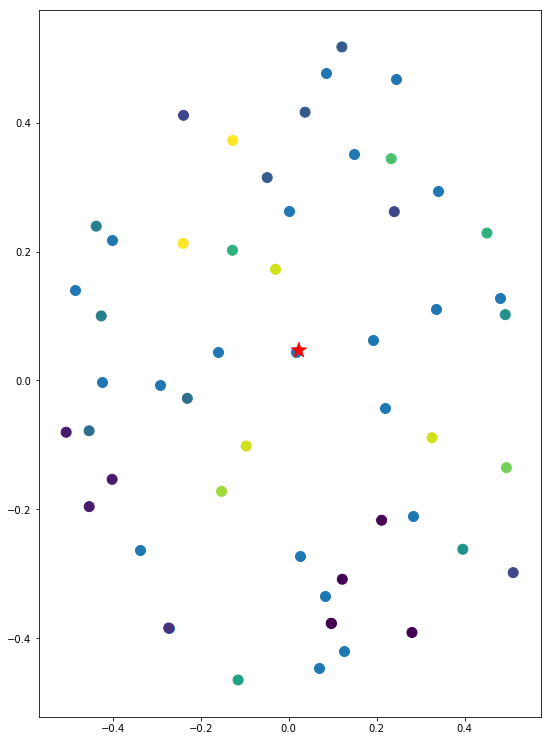

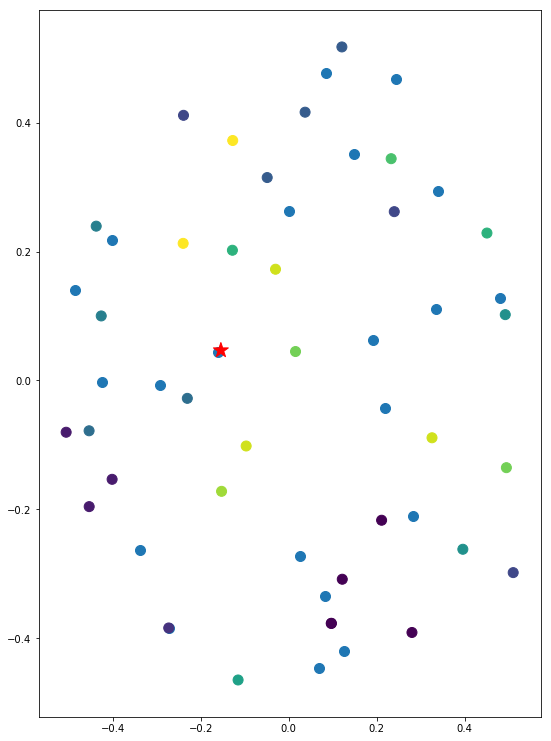

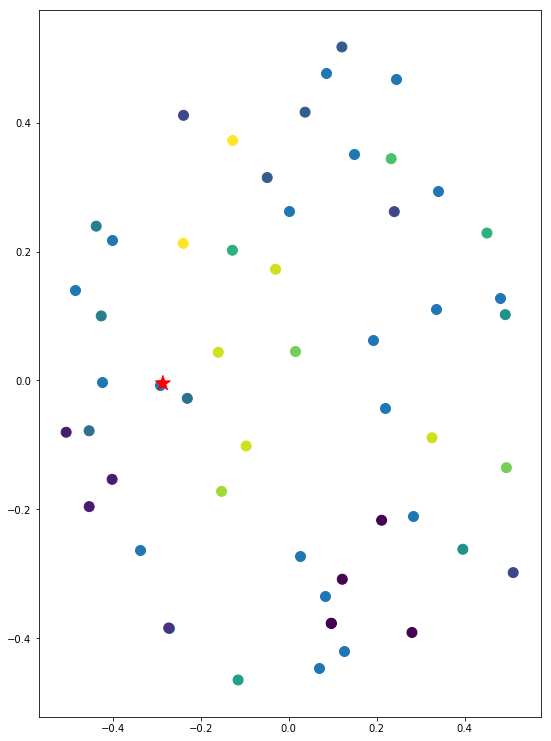

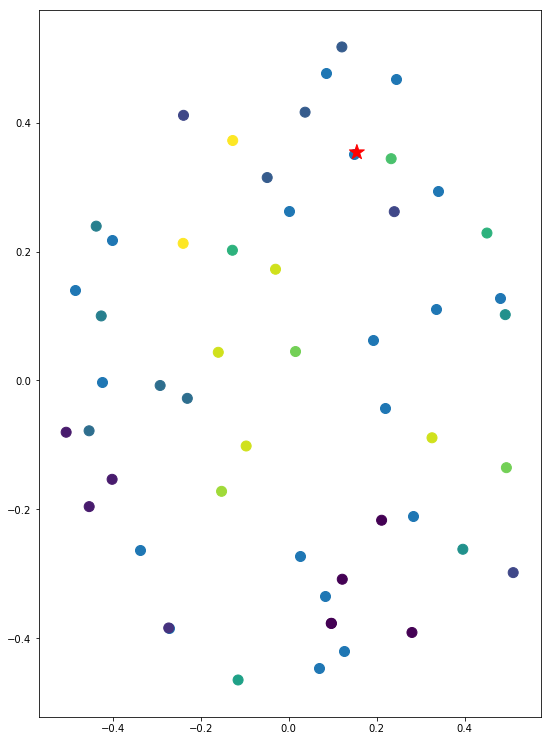

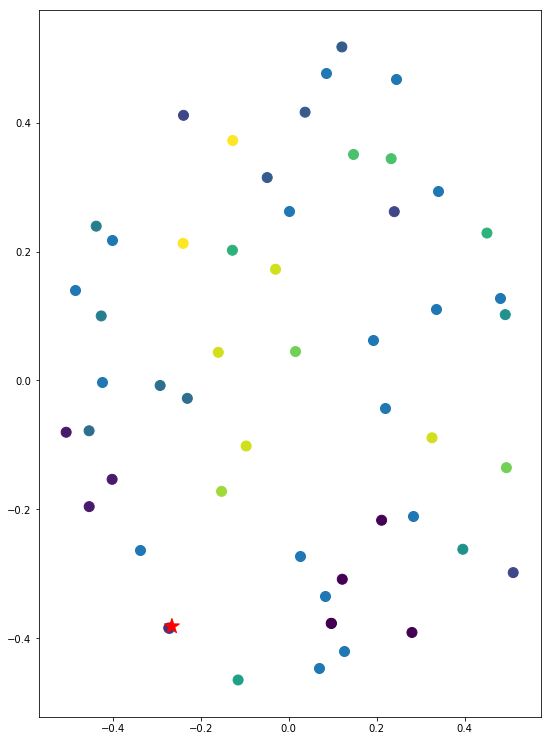

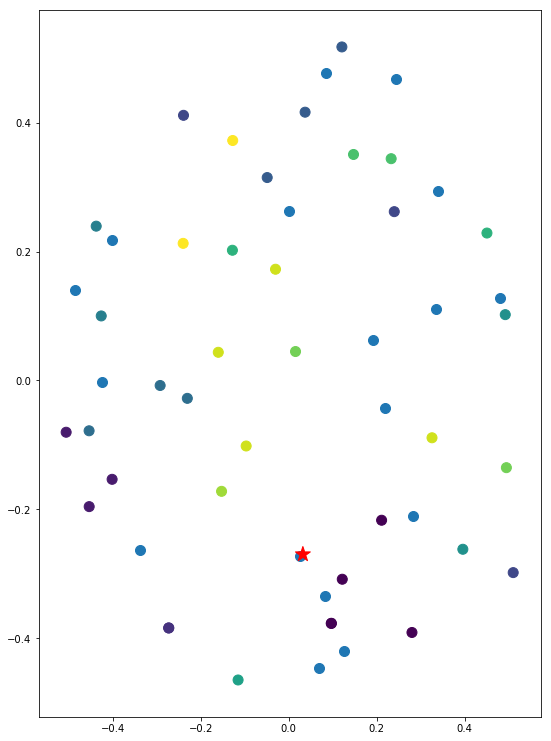

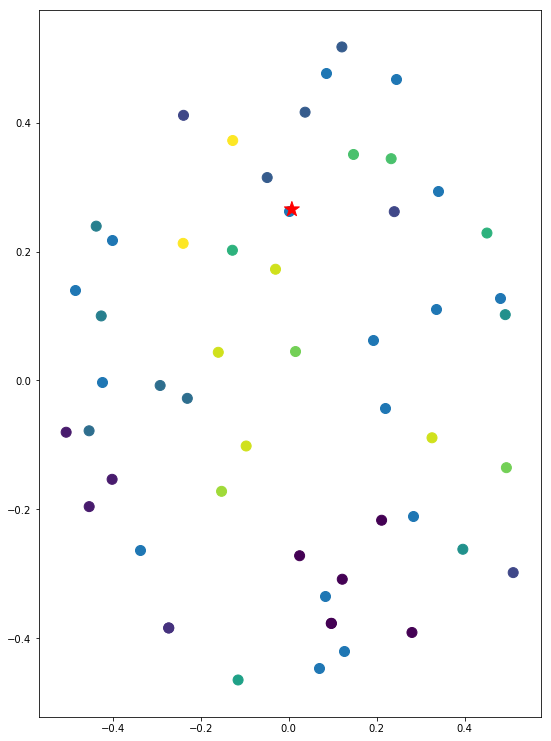

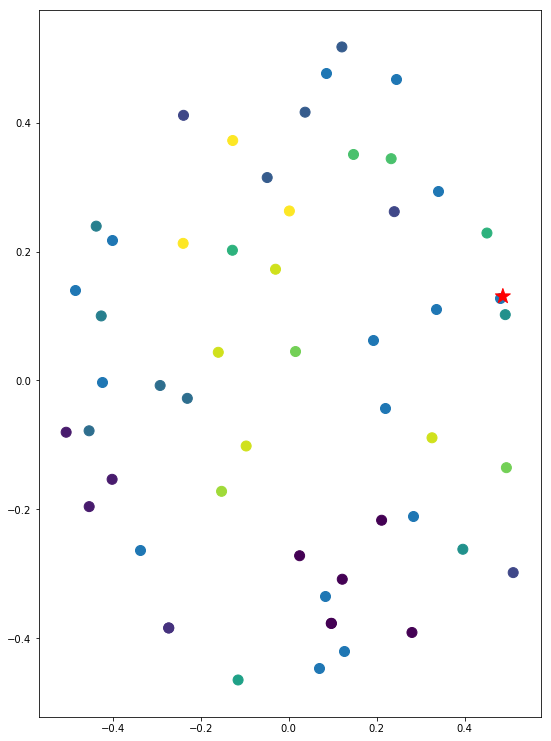

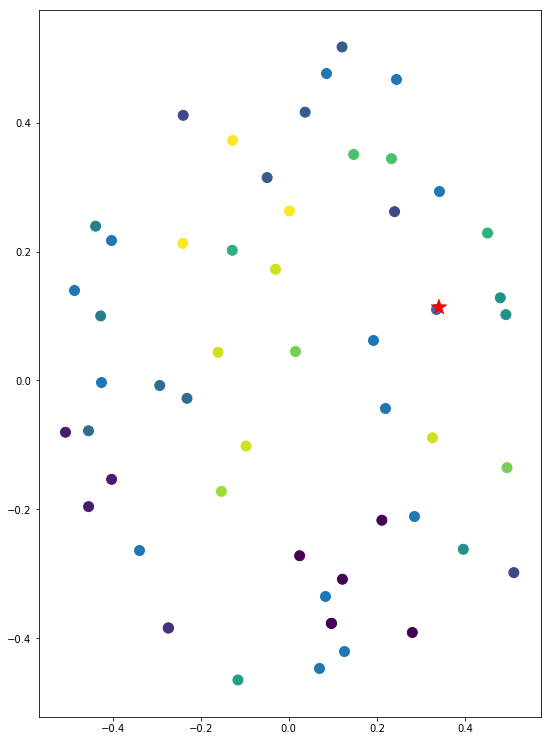

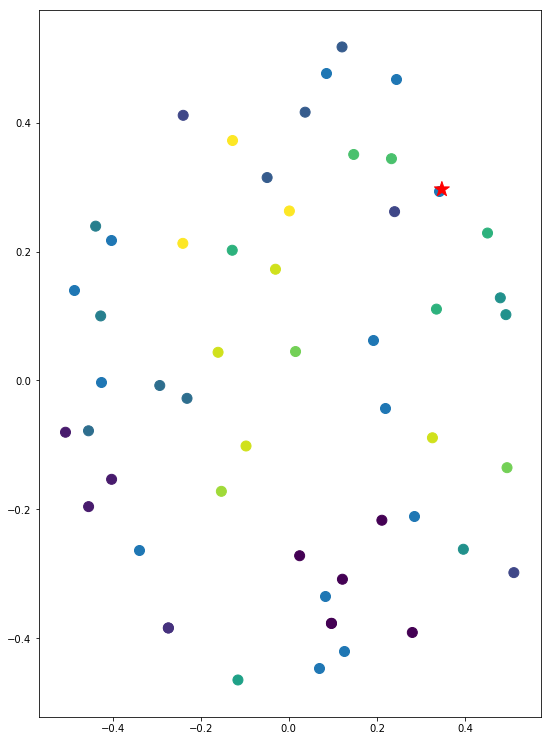

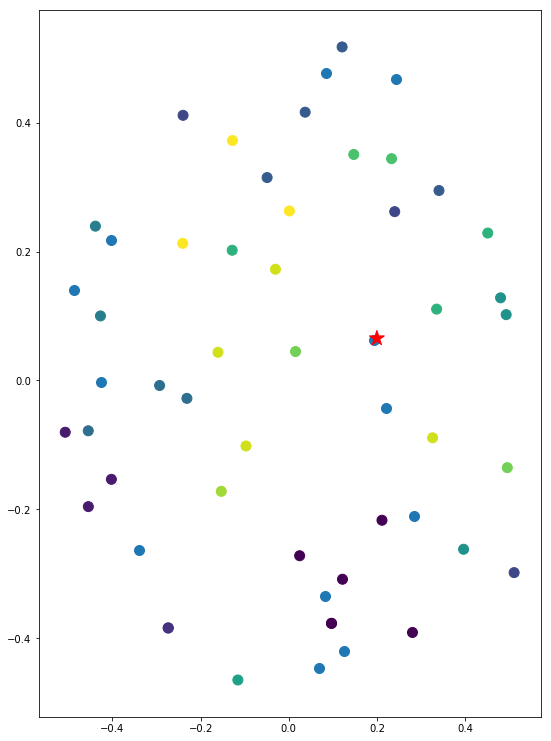

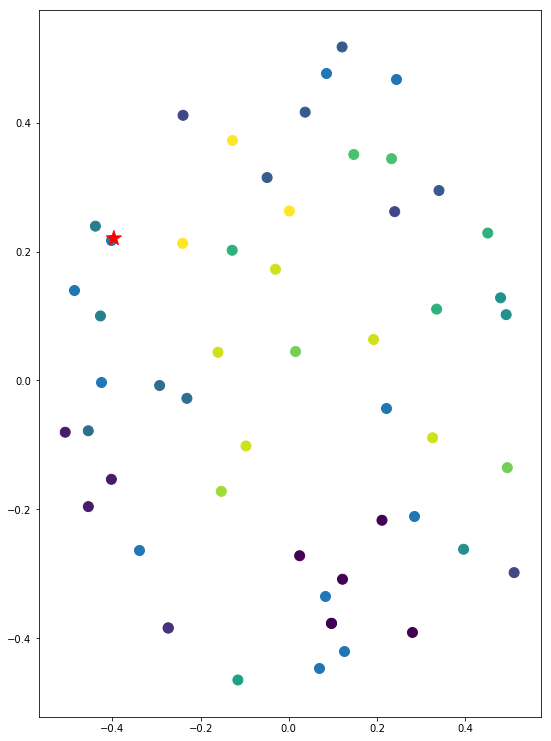

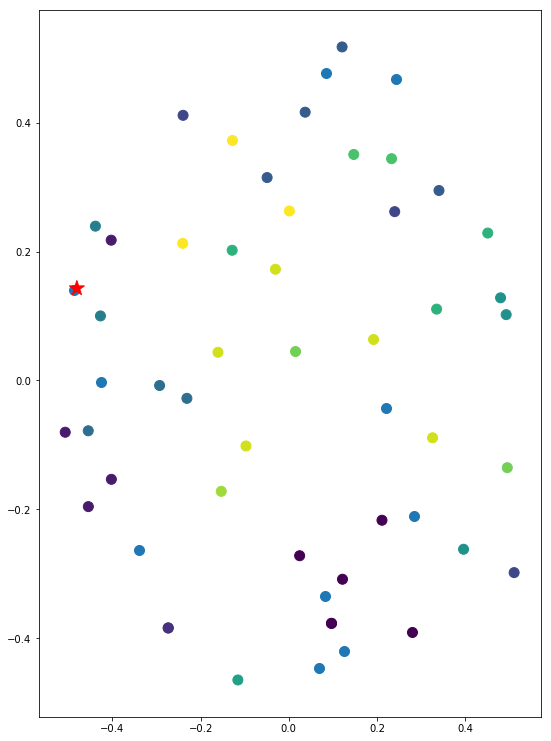

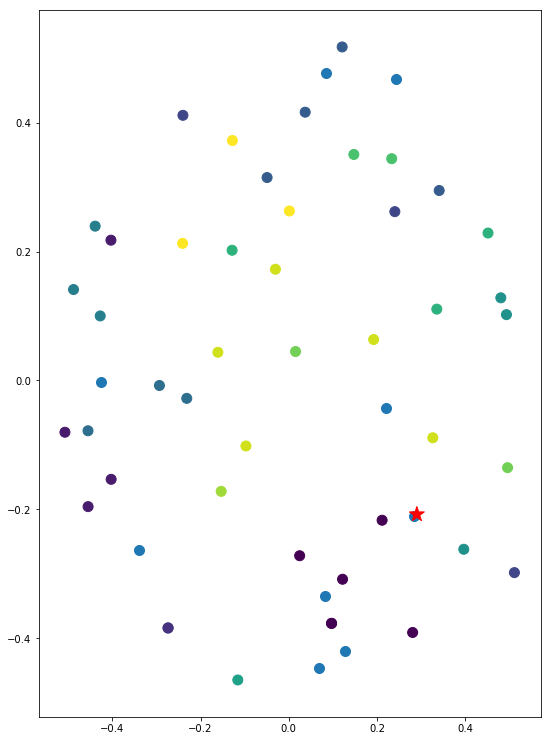

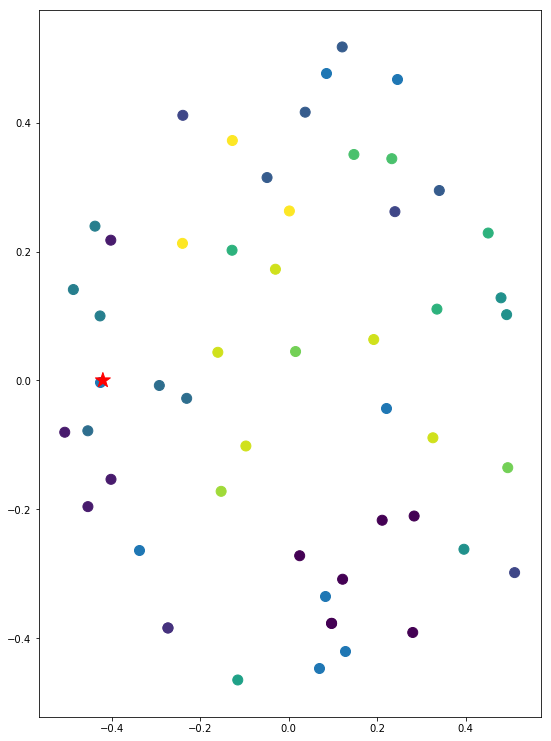

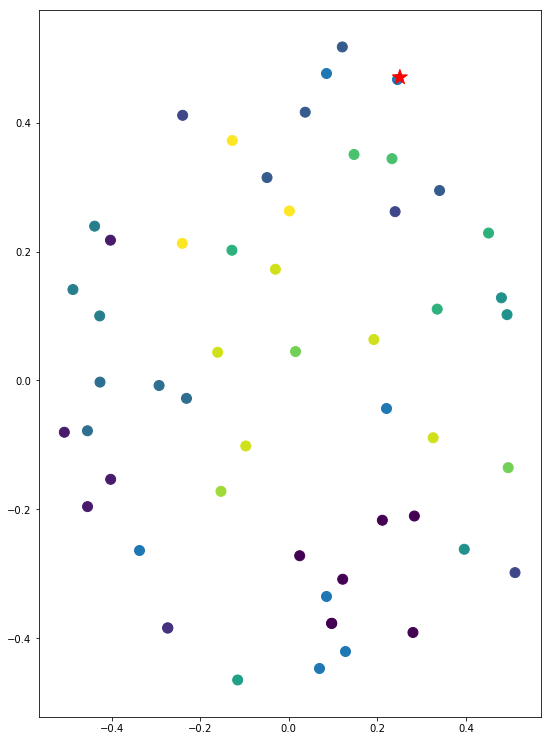

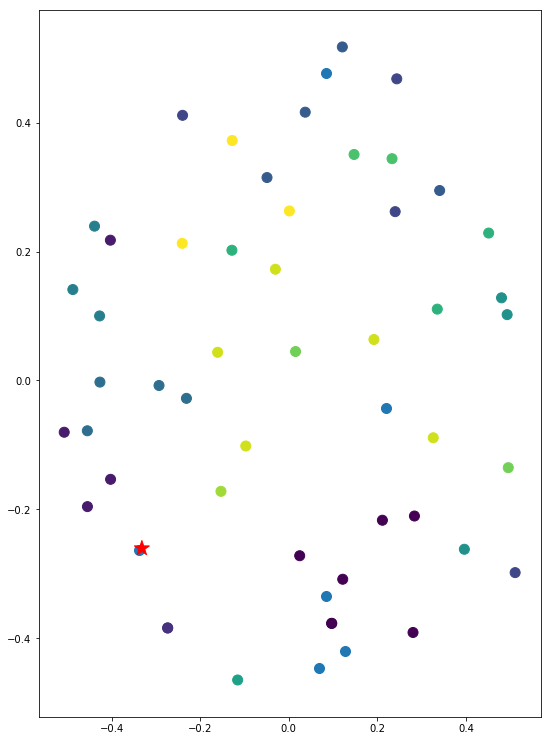

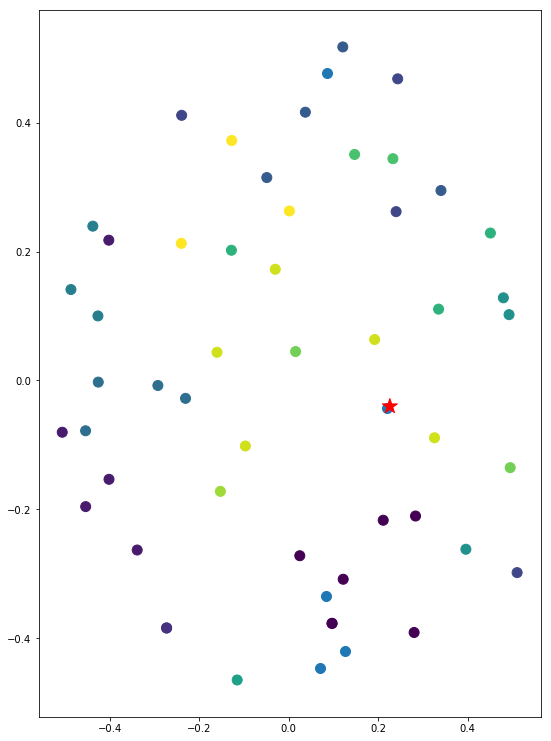

In [14]:
doc = PDFReport()
for i in range(50):
    # Plot sample
    sample_id = get_next_sample(X, Y, W, L)
    
    # Print question
    problem = "Cluster: " + str(y[sample_id] + 1) + "\n" + questions[sample_id]
    solution = solutions[sample_id]
    
    # Plot sample
    plt.figure(figsize=(9,13))
    
    # Get the total number of samples (nS) and total number of classes (nC). nC is not actually used.
    [nS, nC] = X.shape
    # Create the set of unlabelled samples (U)
    U = np.setdiff1d(np.arange(nS), L)
    
    # Plot unlabeled samples
    plt.scatter(x=sample[U,0], y=sample[U,1], s=100)
    
    # Color by class the ones already labeled
    if L:
        a = plt.scatter(x=sample[L,0], y=sample[L,1], c=y[L], s=100)
    
    # Star the queried sample
    plt.scatter(x=sample[sample_id,0], y=sample[sample_id,1], color='r', marker=r'$\star$', s=400)
    
    # Save figure
    plt.savefig("images/solution_%d.png" % sample_id)
#     print("Question %d" % sample_id)
    
    # Print question
#     problem = questions[sample_id]
#     solution = solutions[sample_id]
    
    # Suppose that the student gets it correctly
    # Update X matrix
    X[sample_id] = Y[sample_id]
    L.append(sample_id)
    doc.append_solution(sample_id, problem, solution)
#     print(X)

doc.generate_pdf("problems_20190101")

In [13]:
def normalize_per_row(matrix):
    row_sums = matrix.sum(axis=0)
    matrix_norm = matrix / row_sums[np.newaxis, :]
    return matrix_norm

def sort_distribution(df, columns, MIN_PROB=0.3):
    ids = []

    for col in columns:
        ids = ids + df[df[col] > MIN_PROB].sort_values([col], ascending=False).index.tolist()
    
    for col in columns:
        ids = ids + df.sort_values([col], ascending=False).index.tolist()

    index = df.loc[ids].index.drop_duplicates()
    df_sorted = df.loc[index]
    return df_sorted

In [14]:
import pandas as pd
# word_topic_norm = normalize_per_row(word_topic)
x = ["Topic %d" % (idx+1) for idx in range(model.components_.shape[0])]
y = feature_names
# word_topic_df = pd.DataFrame(word_topic_norm, index=y, columns=x)
word_topic_df = pd.DataFrame(word_topic, index=y, columns=x)
# avg_weight = np.median(word_topic)
avg_weight = np.percentile(word_topic, 75)
word_topic_df = sort_distribution(word_topic_df, x, MIN_PROB=avg_weight)

In [16]:
avg_weight

4.9094076824464343

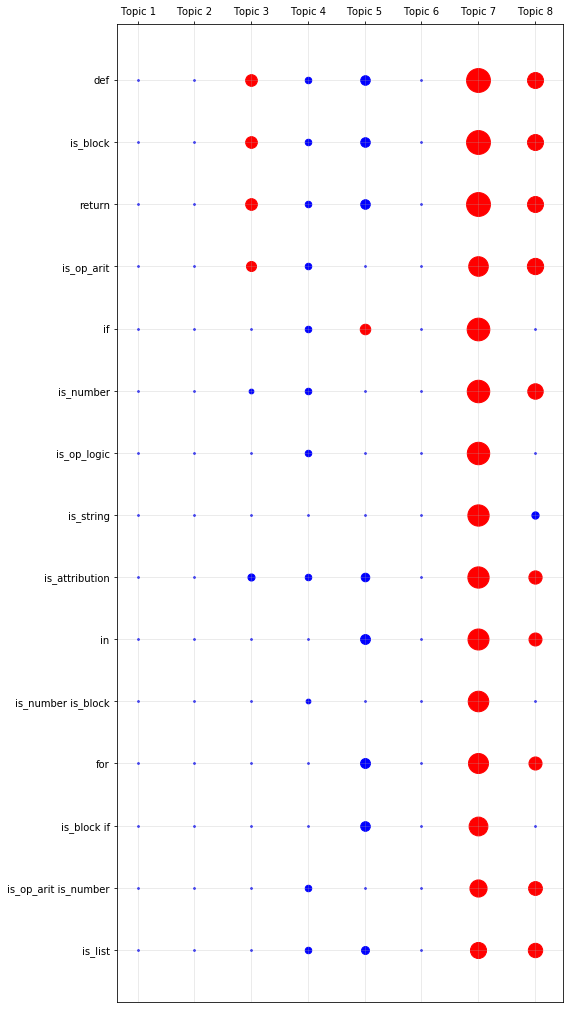

In [17]:
plt.figure(figsize=(8,18))

points = word_topic_df.values
cols = word_topic_df.columns
rows = word_topic_df.index

plt.xticks(range(0,len(cols)), cols)
plt.yticks(range(0,len(rows)), rows)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    bottom=False,      # ticks along the bottom edge are off
    top=True,         # ticks along the top edge are off
    labelbottom=False,
    labeltop=True)
plt.grid(alpha=0.3)

for x_item in range(len(cols)):
    for y_item in range(len(rows)):

#         if rows[y_item] in top_words[x_item]:
        if points[y_item, x_item] > avg_weight:
            c = 'r'
        else:
            
            c = 'b'
        plt.scatter(x_item, y_item, s=points[y_item, x_item]*20, c=c)

plt.gca().invert_yaxis()
plt.savefig('images/problems_1312_lda_4239876583_exp_823.png')
plt.show()

In [80]:
vectorizer = CountVectorizer(analyzer = python_analyzer,
                                   binary=True,
                                   min_df=0.2)
train_data_features = vectorizer.fit_transform(solutions)
analyzer = vectorizer.build_analyzer()
train_features = []
for item in solutions:
    train_features.append(vectorizer.analyzer(item))

In [100]:
import pyLDAvis.sklearn
 
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(model, train_data_features, vectorizer, mds='pcoa', sort_topics=False)
panel

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.026736  0.124858       1        1  21.252373
1      0.031251 -0.025002       2        1  29.494624
2     -0.134422 -0.064660       3        1  27.974283
3      0.129907 -0.035197       4        1  21.278720, topic_info=     Category       Freq                            Term      Total  loglift  \
term                                                                           
16    Default  17.000000       is_block is_indent return  17.000000  30.0000   
28    Default  17.000000                is_indent return  17.000000  29.0000   
18    Default  12.000000                 is_class append  12.000000  28.0000   
0     Default  12.000000                          append  12.000000  27.0000   
41    Default  16.000000                           range  16.000000  26.0000   
12    Default  15.000000          is_attribution is_list  15.000000  25.0000   
10    Default  15.000000                        in range  15.000000  24.0000   
24    Default  18.000000      is_dedent is_dedent return  18.000000  23.0000   
35    Default  38.000000                      is_op_arit  38.000000  22.0000   
23    Default  29.000000             is_dedent is_dedent  29.000000  21.0000   
8     Default  32.000000                              if  32.000000  20.0000   
22    Default  17.000000         is_dedent else is_block  17.000000  19.0000   
3     Default  17.000000                            else  17.000000  18.0000   
4     Default  17.000000                   else is_block  17.000000  17.0000   
21    Default  17.000000                  is_dedent else  17.000000  16.0000   
5     Default  17.000000         else is_block is_indent  17.000000  15.0000   
36    Default  26.000000            is_op_arit is_number  26.000000  14.0000   
17    Default  21.000000                        is_class  21.000000  13.0000   
29    Default  28.000000                         is_list  28.000000  12.0000   
43    Default  11.000000                return is_string  11.000000  11.0000   
15    Default  22.000000           is_block is_indent if  22.000000  10.0000   
27    Default  22.000000                    is_indent if  22.000000   9.0000   
11    Default  38.000000                  is_attribution  38.000000   8.0000   
2     Default  14.000000                            elif  14.000000   7.0000   
20    Default  14.000000                  is_dedent elif  14.000000   6.0000   
33    Default  13.000000             is_number is_dedent  13.000000   5.0000   
6     Default  33.000000                             for  33.000000   4.0000   
7     Default  11.000000                               i  11.000000   3.0000   
25    Default  29.000000                is_dedent return  29.000000   2.0000   
34    Default  14.000000            is_number is_op_arit  14.000000   1.0000   
...       ...        ...                             ...        ...      ...   
28     Topic4  16.810638                is_indent return  17.546571   1.5046   
16     Topic4  16.810638       is_block is_indent return  17.546571   1.5046   
43     Topic4   4.834458                return is_string  11.390355   0.6905   
33     Topic4   5.663469             is_number is_dedent  13.401419   0.6861   
27     Topic4   7.433299                    is_indent if  22.024529   0.4613   
15     Topic4   7.433299           is_block is_indent if  22.024529   0.4613   
20     Topic4   4.708505                  is_dedent elif  14.456723   0.4257   
2      Topic4   4.708505                            elif  14.456723   0.4257   
39     Topic4   4.766308  is_op_logic is_number is_block  15.355616   0.3776   
38     Topic4   4.749812           is_op_logic is_number  16.345352   0.3116   
37     Topic4   7.614526                     is_op_logic  26.946465   0.2837   
5      Topic4   4.905976         else is_block is_indent  17.402737   0.2813   
21     Topic4   4.905976         

In [96]:
from gensim import corpora, models

In [97]:
dictionary = corpora.Dictionary(train_features)
corpus = [dictionary.doc2bow(text) for text in train_features]
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=4)

/home/lmoraes/miniconda3/envs/machine_teaching/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/lmoraes/miniconda3/envs/machine_teaching/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/home/lmoraes/miniconda3/envs/machine_teaching/lib/python3.6/site-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generato

In [98]:
lda.show_topics()

[(0,
  '0.029*"is_number" + 0.016*"is_block is_indent" + 0.015*"is_indent" + 0.015*"is_block" + 0.013*"is_dedent" + 0.010*"is_op_logic is_number" + 0.010*"is_op_arit" + 0.009*"is_attribution" + 0.009*"is_op_logic" + 0.009*"is_number is_block"'),
 (1,
  '0.023*"is_number" + 0.020*"is_block" + 0.019*"is_indent" + 0.018*"is_dedent" + 0.016*"is_block is_indent" + 0.015*"is_attribution" + 0.009*"return" + 0.009*"is_op_arit" + 0.007*"is_string" + 0.007*"is_number is_number"'),
 (2,
  '0.027*"is_dedent" + 0.025*"is_block is_indent" + 0.023*"is_indent" + 0.020*"is_block" + 0.019*"is_number" + 0.013*"is_op_arit" + 0.012*"is_attribution" + 0.010*"is_string" + 0.010*"is_op_logic" + 0.010*"is_list"'),
 (3,
  '0.026*"is_block" + 0.024*"is_number" + 0.018*"is_indent" + 0.018*"is_block is_indent" + 0.018*"is_attribution" + 0.014*"is_dedent" + 0.013*"is_op_arit" + 0.009*"is_op_arit is_number" + 0.008*"is_op_logic" + 0.007*"is_string"')]

In [99]:
import pyLDAvis.gensim

pyLDAvis.gensim.prepare(lda, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.016153  0.023477       1        1  46.918850
3      0.025379 -0.016116       2        1  23.606613
1     -0.030952  0.002361       3        1  16.338646
0     -0.010580 -0.009722       4        1  13.135886, topic_info=     Category        Freq                            Term       Total  \
term                                                                    
25    Default  162.000000                       is_number  162.000000   
11    Default  155.000000                        is_block  155.000000   
106   Default  101.000000                  is_attribution  101.000000   
244   Default   38.000000           is_op_logic is_number   38.000000   
15    Default  149.000000                       is_indent  149.000000   
619   Default   21.000000             is_number is_number   21.000000   
954   Default   14.000000                           month   14.000000   
242   Default   43.000000              is_number is_block   43.000000   
2062  Default    9.000000                           digit    9.000000   
12    Default  151.000000              is_block is_indent  151.000000   
30    Default   42.000000            is_op_arit is_number   42.000000   
975   Default   11.000000   is_number is_number is_number   11.000000   
243   Default   42.000000    is_number is_block is_indent   42.000000   
14    Default  154.000000                       is_dedent  154.000000   
29    Default   87.000000                      is_op_arit   87.000000   
131   Default   62.000000                     is_op_logic   62.000000   
38    Default   59.000000                          return   59.000000   
184   Default   21.000000                             int   21.000000   
958   Default   10.000000     month is_op_logic is_number   10.000000   
957   Default   10.000000               month is_op_logic   10.000000   
245   Default   28.000000  is_op_logic is_number is_block   28.000000   
13    Default   29.000000       is_block is_indent return   29.000000   
979   Default    6.000000      return is_number is_dedent    6.000000   
2063  Default    4.000000                     digit digit    4.000000   
978   Default    6.000000                return is_number    6.000000   
352   Default   27.000000                               i   27.000000   
28    Default   21.000000             is_number is_dedent   21.000000   
973   Default    6.000000      is_indent return is_number    6.000000   
960   Default    6.000000                        or month    6.000000   
47    Default   36.000000                        is_class   36.000000   
...       ...         ...                             ...         ...   
951    Topic4    1.923572                    is_number or    7.282803   
947    Topic4    0.837827                        if month    2.645454   
971    Topic4    0.988060                    in is_number    3.260302   
975    Topic4    2.719701   is_number is_number is_number   11.985578   
243    Topic4    6.697405    is_number is_block is_indent   42.082581   
131    Topic4    8.719056                     is_op_logic   62.394714   
619    Topic4    3.989178             is_number is_number   21.581390   
12     Topic4   15.348146              is_block is_indent  151.994034   
553    Topic4    2.860495  is_number is_op_arit is_number   14.295011   
15     Topic4   15.091133                       is_indent  149.092072   
245    Topic4    4.594899  is_op_logic is_number is_block   28.511744   
11     Topic4   14.689958                        is_block  155.020477   
29     Topic4    9.464514                      is_op_arit   87.831215   
352    Topic4    4.381682                               i   27.501194   
14     Topic4   13.131330                       is_dedent  154.363541   
106    Topic4    9.240771                  is_attribution  101.742111   
38     Topic4    6.356514                          retur

### References
[1] Johns, E., Aodha, O. Mac & Brostow, G. J. Becoming the expert - Interactive multi-class machine teaching. in Proceedings of the IEEE Computer Society Conference on Computer Vision and Pattern Recognition (2015). doi:10.1109/CVPR.2015.7298877

[2] Zhu, X., Lafferty, J. & Ghahramani, Z. Combining Active Learning and Semi-Supervised Learning Using Gaussian Fields and Harmonic Functions Xiaojin. … Data Mach. Learn. … (2003).